# Exploring time series in python

**Date started**: 21st June 2022

**Guide**: https://rishi-a.github.io/2020/05/25/granger-causality.html

**Factors to consider altering/adding**: 
* Normalisation
* Transformation (log) - **added to this script**
* Checking all VAR fit stats
* Lag

In [1]:
# Packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.api import VAR

/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Use this to install any packages required in general:

# import subprocess
# import sys

# def install(package):
#    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
# install("johansen")

In [3]:
# Useful dates


bank_holidays = ["2020-01-01","2020-04-10","2020-04-13","2020-05-08",
                "2020-05-25","2020-08-31","2020-12-25","2020-12-28",
                "2021-01-01","2021-04-02","2021-04-05","2021-05-03",
                "2021-05-31","2021-08-30","2021-12-27","2021-12-28",
                "2022-01-03","2022-04-15","2022-04-18","2022-05-02"]


type(bank_holidays[0]) # They are currently strings
bank_holidays = [dt.datetime.strptime(item, "%Y-%m-%d") for item in bank_holidays]
type(bank_holidays[0]) # Now datetime objects

lockdown_1_start = dt.datetime.strptime("2020-03-26","%Y-%m-%d")
lockdown_1_end = dt.datetime.strptime("2020-06-15","%Y-%m-%d")

lockdown_2_start = dt.datetime.strptime("2020-11-05","%Y-%m-%d")
lockdown_2_end = dt.datetime.strptime("2020-12-02","%Y-%m-%d")

lockdown_3_start = dt.datetime.strptime("2021-01-06","%Y-%m-%d")
lockdown_3_end = dt.datetime.strptime("2021-04-21","%Y-%m-%d")


REACT_start = dt.datetime.strptime("2020-05-01","%Y-%m-%d")

from dateutil.relativedelta import relativedelta
start_date = REACT_start
print(type(start_date))
end_date = lockdown_2_start-relativedelta(months=1)

print(f'Start date is: {start_date}, i.e. start of REACT data')
print(f'End date is: {end_date}, i.e. one month before the end of lockdown 1')

<class 'datetime.datetime'>
Start date is: 2020-05-01 00:00:00, i.e. start of REACT data
End date is: 2020-10-05 00:00:00, i.e. one month before the end of lockdown 1


## Time Series

Exploring Granger Causality using tutorial - https://rishi-a.github.io/2020/05/25/granger-causality.html

In [4]:
# Loading data

mob_long = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_long.csv", index_col='date',parse_dates=['date'])
mob_wide = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_wide.csv", index_col='date',parse_dates=['date'])
prev = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Time_series_analysis/Ouputs/Tibbles/prev_smooth_tibble.csv", index_col='d_comb',parse_dates=['d_comb'])

mob_long.index = pd.to_datetime(mob_long.index)
mob_wide.index = pd.to_datetime(mob_wide.index)
mob_wide = mob_wide.sort_index()
prev = prev.sort_index()

# Using log prevalence

prev['p']=np.log(prev['p'])

In [5]:
print("Column names in the long dataset are:")
for col in mob_long.columns:
    print(col)
    
print("Column names in the wide dataset are:")
for col in mob_wide.columns:
    print(col)
    
print("Column names in the prevalence dataset are:")
for col in prev.columns:
    print(col)

Column names in the long dataset are:
Unnamed: 0
region
type_mobility
mobility
Column names in the wide dataset are:
Unnamed: 0
region
retail_recreation
grocery_pharmacy
parks
transit_stations
workplaces
residential
retail_recreation_av
grocery_pharmacy_av
parks_av
transit_stations_av
workplaces_av
residential_av
Column names in the prevalence dataset are:
Unnamed: 0
x
p
lb_2.5
lb_25
ub_97.5
ub_75
region


In [6]:
mob_wide.head()

,Unnamed: 0,region,retail_recreation,grocery_pharmacy,parks,transit_stations,workplaces,residential,retail_recreation_av,grocery_pharmacy_av,parks_av,transit_stations_av,workplaces_av,residential_av
date,,,,,,,,,,,,,,
2020-02-15,new.2662,NORTH EAST,-6.375000,-4.625000,-33.875000,-7.000000,-1.875000,1.833333,-31.553571,-12.357143,-5.636905,-25.553571,-27.910714,9.681973
2020-02-15,new.5922,WEST MIDLANDS,-12.571429,-6.428571,-41.000000,-11.285714,-4.000000,2.285714,-34.408163,-13.591837,-4.268707,-29.755102,-30.102041,10.452381
2020-02-15,new.1032,EAST MIDLANDS,-9.222222,-5.222222,-35.125000,-7.375000,-4.333333,1.875000,-34.214286,-13.607143,-3.178571,-31.607143,-29.884921,10.265873
2020-02-15,new.3477,NORTH WEST,-9.200000,-5.700000,-34.555556,-11.200000,-3.000000,2.111111,-31.414286,-12.671429,2.460317,-29.242857,-29.628571,10.186111
2020-02-15,new.1847,LONDON,-11.000000,-8.000000,-34.000000,-10.000000,-3.000000,2.000000,-39.428571,-17.714286,-10.714286,-41.285714,-36.714286,13.714286


In [7]:
# Focusing on London
mob_london = mob_wide[mob_wide['region']=="LONDON"]
prev_london = prev[prev['region']=="LONDON"]

# Only including columns of interest
mob_london = mob_london[['workplaces_av']]
prev_london = prev_london[['p']]

**Can change lag input here!**

In [8]:
# Shifting by 6 weeks - as calculated by CCF of log(prev) vs mobility

shift_lag = -6*7
print(f'Lag used is {shift_lag} days')

mob_london['workplaces_av']=mob_london['workplaces_av'].shift(shift_lag)
mob_london.head()

Lag used is -42 days


,workplaces_av
date,
2020-02-15,-35.142857
2020-02-16,-43.571429
2020-02-17,-49.714286
2020-02-18,-58.714286
2020-02-19,-57.000000


In [9]:
# Focussing on specified interval
mob_london = mob_london.loc[start_date:end_date]
prev_london = prev_london.loc[start_date:end_date]


In [10]:
# Merging into a combined London dataframe

london = pd.merge(mob_london, prev_london, how='inner', left_index=True, right_index=True)
london.head()

,workplaces_av,p
date,,
2020-05-01,-51.285714,-4.295143
2020-05-02,-44.714286,-4.400168
2020-05-03,-38.000000,-4.505304
2020-05-04,-35.714286,-4.608653
2020-05-05,-53.285714,-4.713554


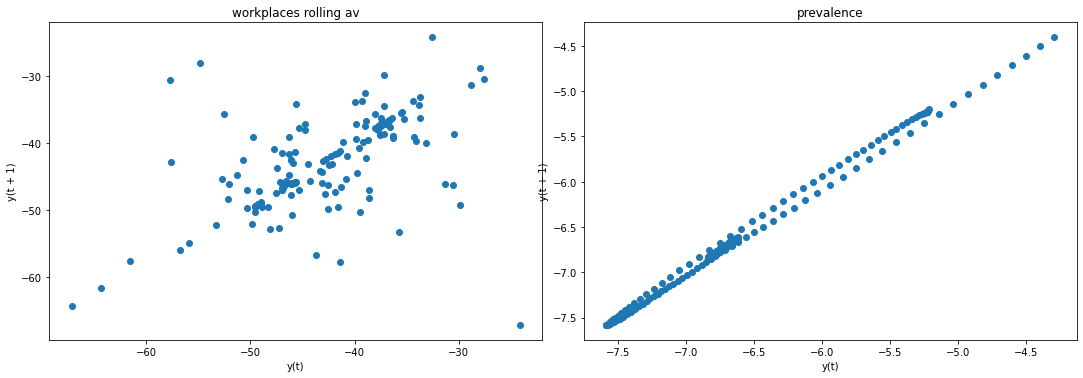

In [11]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av');

lag_plot(london['p'], ax=ax5)
ax5.set_title('prevalence');

In [12]:
raw_london = london.copy(deep=True)

In [13]:
# Differencing - using the rolling average as clear differencing needed, and as well as prevalence

london['workplaces_av'] = london['workplaces_av'] - london['workplaces_av'].shift(1)
london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()
london.head()

,workplaces_av,p
date,,
2020-05-02,6.571429,-0.105025
2020-05-03,6.714286,-0.105136
2020-05-04,2.285714,-0.103349
2020-05-05,-17.571429,-0.104902
2020-05-06,1.142857,-0.107196


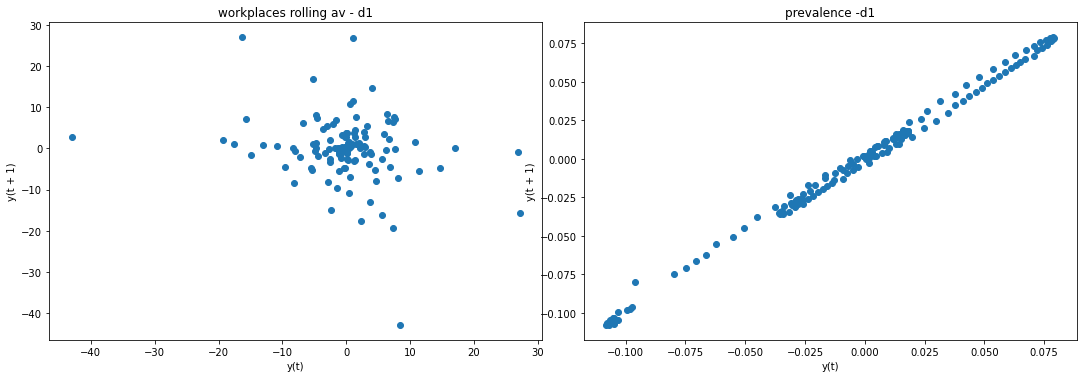

In [14]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('prevalence -d1');

In [15]:
# There is still clear autocorrelation for prevalence so shift this once again

london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()
london.head()

,workplaces_av,p
date,,
2020-05-03,6.714286,-0.000111
2020-05-04,2.285714,0.001787
2020-05-05,-17.571429,-0.001553
2020-05-06,1.142857,-0.002295
2020-05-07,3.857143,0.000110


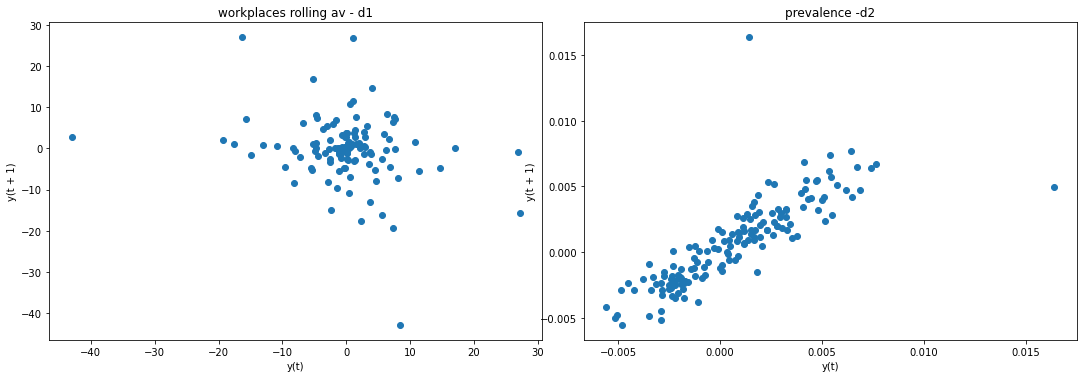

In [16]:
# Plotting again
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('prevalence -d2');

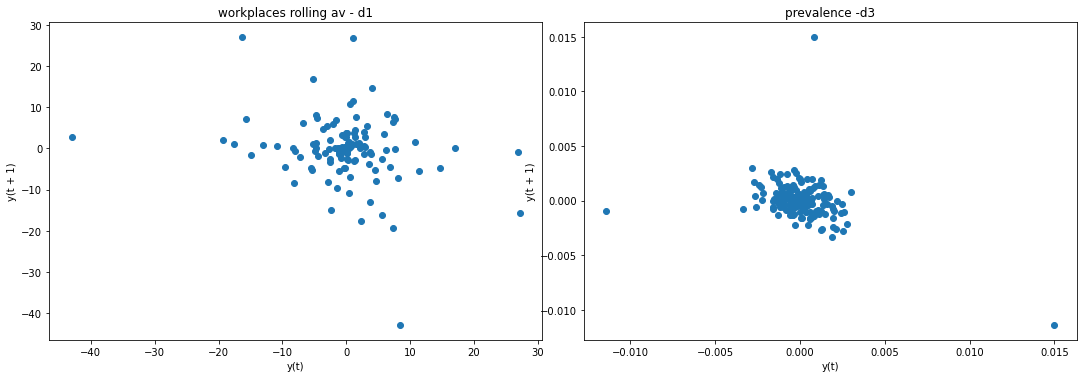

In [17]:
# Differencing prevalence again

# There is still clear autocorrelation for prevalence so shift this once again

london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()
london.head()

# Plotting again
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('prevalence -d3');

Looks ok now - so mobility is differenced once, prevalence 3 times

In [18]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
from statsmodels.tsa.stattools import adfuller

X1 = np.array(london['workplaces_av'])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
X2 = np.array(london['p'])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    


ADF Statistic: -5.798911
p-value: 0.000000
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578
ADF Statistic: -18.695825
p-value: 0.000000
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


In [19]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

# now stationary

KPSS Statistic: 0.211716371845378
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.06704540709040906
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater 

Overall result to far -  both stationary:  
* Mobility - d=1
* Prevalence - logged, d=3

In [20]:
# split data into train and test. We will need this later for VAR analysis

msk = np.random.rand(len(london)) < 0.8
train = london[msk]
test = london[~msk]

Result: lag plot is confirmatory with ADF test and KPSS. Uses moving average and 3 differences

Next: setting up VAR model

**Step 2**: Let the maximum order of integration for the group of time-series be d. So, if there are two time-series and one is found to be I(1) and the other is I(2), then d = 2. If one is I(0) and the other is I(1), then m = 1, etc.

**Result**: Saw above that in this case d=1

**Step 3**: Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, **you must not difference the data, no matter what you found at Step 1**.

**Step 4**: Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.


**Note**: try running like this first, then incorporate info on the lag later


In [21]:
# obtain the lag P for VAR

raw_london = raw_london.dropna()
model = VAR(np.array(raw_london)) #recall that rawData is w/o difference operation


In [22]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -2.212287232909657
BIC :  -2.0939644042441907
FPE :  0.109451103398188
HQIC:  -2.164224797312116 

Lag Order = 2
AIC :  -3.3832786909158536
BIC :  -3.185210852916348
FPE :  0.03393758669852701
HQIC:  -3.3028202540231706 

Lag Order = 3
AIC :  -3.5777733512319854
BIC :  -3.299258040101407
FPE :  0.027941479942897685
HQIC:  -3.4646307583259075 

Lag Order = 4
AIC :  -3.628617342219313
BIC :  -3.2689416000824347
FPE :  0.026560385956608513
HQIC:  -3.482498367517643 

Lag Order = 5
AIC :  -3.6323468568665858
BIC :  -3.1907870137324683
FPE :  0.026467986669129077
HQIC:  -3.4529551279350774 

Lag Order = 6
AIC :  -3.6158179939912674
BIC :  -3.091639443960516
FPE :  0.026918852979830647
HQIC:  -3.402852914523756 

Lag Order = 7
AIC :  -3.561585903793009
BIC :  -2.9540428753273096
FPE :  0.02843344562032027
HQIC:  -3.314742574725127 

Lag Order = 8
AIC :  -3.5068143374500704
BIC :  -2.8151496575148527
FPE :  0.03005472426961889
HQIC:  -3.2257834763715723 

Lag Order = 9
AI

**Result**: The lag order **p=5** on the basis of AIC  
**Step 5**: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [23]:
model = VAR(np.asarray(train))
model_fitted = model.fit(5)

In [24]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(london.columns, out):
    print(col, ':', round(val, 2))

workplaces_av : 2.07
p : 2.0


**Result**: There is no significant correlation between in the residuals

**Step 6**: If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.  

**Johansen's test**:   
H0: There are no cointegrating equations 

In [25]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import JohansenTestResult

# Function from here : http://web.pdx.edu/~crkl/ceR/Python/example14_3.py

"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""



def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

result = coint_johansen(np.asarray(london),0,1)
joh_output(result)

   max_eig_stat  trace_stat
0    111.292306  200.490005
1     89.197700   89.197700 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



**Result**: Greater than all critical values, thus p<0.05 - Thus rejecting the null hypothesis. Thus they are cointegrated.  

In [26]:
# Trying the other test done in the tutorial
# This uses the augmented Engle-Granger two-step cointegration test. Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.

import statsmodels.tsa.stattools as ts 

result=ts.coint(london['workplaces_av'], london['p'], return_results=True)
result
# Note the results includes: t stat, p value, [1% critical value, 5% critical value, 10% critical value]

(-5.7568437662039615,
 5.331205434521528e-06,
 array([-3.97094276, -3.37716724, -3.07284556]))

**Result** : The p-values < 0.05. Thus rejecting the null hypothesis. Thus they are cointegrated using this alternative test too.


**Step 7**: No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.  
**Step 8**: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.  

In [27]:
model = VAR(np.asarray(train))
model_fitted = model.fit(5)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

5


**Step 9 and Step 10**: Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

^ I'm not sure I've done step 8 right, and not sure what it means by the 'extra' lags above?

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=lag_order #becuase we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

o = grangers_causation_matrix(train, variables = train.columns)  

In [29]:
o

,workplaces_av_x,p_x
workplaces_av_y,1.0000,0.4104
p_y,0.7924,1.0000


In [30]:
print("p value for prevalence causing mobility is:",o.iloc[0,1],'\n')
print("p value for mobility causing prevalence is:",o.iloc[1,0],'\n')

p value for prevalence causing mobility is: 0.4104 

p value for mobility causing prevalence is: 0.7924 



**Result**: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). Both p values > 0.05 -> no granger causality

**Step 11**: Finally, look back at what you concluded in Step 6 about cointegration.  

If two or more time-series are cointegrated, then there must be Granger causality between them - either one-way or in both directions. However, the converse is not true.

So, if your data are cointegrated but you don't find any evidence of causality, you have a conflict in your results. (This might occur if your sample size is too small to satisfy the asymptotics that the cointegration and causality tests rely on.) If you have cointegration and find one-way causality, everything is fine. (You may still be wrong about there being no causality in the other direction.) If your data are not cointegrated, then you have no cross-check on your causality results.


**Now diverging from the tutorial, exploring forecasting**

In [31]:
# Exploring forecasting

# Firstly summary of the model
model
model_fitted = model.fit(6)
model_fitted.summary()
# y1 is presumably -> mobility, y2 is presumably -> prevalence

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Jun, 2022
Time:                     10:29:06
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.90563
Nobs:                     121.000    HQIC:                  -8.26239
Log likelihood:           197.253    FPE:                0.000202512
AIC:                     -8.50638    Det(Omega_mle):     0.000165124
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.094768         0.600776            0.158           0.875
L1.y1        -0.222462         0.094085           -2.364           0.018
L1.y2       264.043458       325.977907            0.810           0.418
L2.y1        -0.250735

In [32]:
# Despite confirming that mobility Granger causes prevalence, none of the coefficients are significant for mobility (y1) for the equation for y2 (prevalence). However, nor are any of the prevalence ones either??

In [33]:
# https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

lagged_Values = train.values[-8:]
pred = model_fitted.forecast(y=lagged_Values, steps=12) 
pred

array([[-1.78929338e+00, -1.23921591e-04],
       [ 4.20647828e-01,  7.17264968e-05],
       [-3.92590939e-01,  1.65414176e-04],
       [ 9.81574646e-02,  4.46906288e-05],
       [ 2.24933282e-01, -2.56741899e-05],
       [ 7.80445749e-01, -1.59083757e-05],
       [ 4.74358634e-02,  4.17162603e-05],
       [-2.64476655e-01,  2.88740320e-05],
       [-2.55112200e-01, -2.44499844e-06],
       [ 1.06608058e-01,  2.40280395e-06],
       [ 6.08878805e-02,  3.05446646e-05],
       [ 3.99396872e-02,  2.96084749e-05]])